# 04 - EM Induction Physics and Skin Depth

Frequency-domain electromagnetic (FDEM) induction is HIRT's primary sensing
modality. This notebook covers the underlying physics:

1. **Skin depth** — how EM fields attenuate in conductive ground
2. **Conductive sphere response** — analytical model for buried metallic objects
3. **1D layered-earth FDEM** — apparent conductivity from horizontal coplanar coils
4. **HIRT coil geometry** — the probe's TX/RX configuration

**Scenario:** `swamp-crash-site.json` (high-conductivity layered terrain)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

from geosim.em.skin_depth import skin_depth, skin_depth_practical, MU_0
from geosim.em.fdem import (
    secondary_field_conductive_sphere, fdem_response_1d, fdem_forward,
)
from geosim.em.coil import CoilConfig, ProbeCoilSet, hirt_default_coils
from geosim.scenarios.loader import load_scenario

%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['figure.dpi'] = 100

## 1. Skin Depth Fundamentals

The skin depth $\delta$ is the depth at which EM fields attenuate to 1/e (~37%):

$$\delta = \frac{1}{\sqrt{\pi f \mu \sigma}} \approx 503 \sqrt{\frac{\rho}{f}}$$

Lower frequency = deeper penetration. Higher conductivity = shallower penetration.

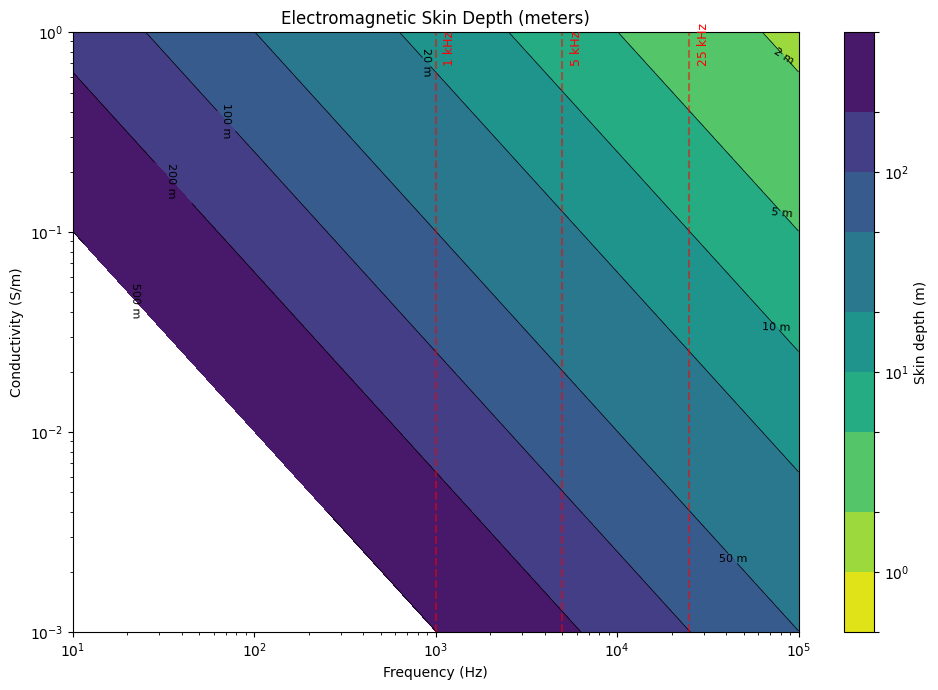

In [2]:
# Frequency x conductivity contour map of skin depth
freqs = np.logspace(1, 5, 200)      # 10 Hz to 100 kHz
sigmas = np.logspace(-3, 0, 200)     # 0.001 to 1 S/m
F, S = np.meshgrid(freqs, sigmas)

delta = skin_depth(F, S)

fig, ax = plt.subplots(figsize=(10, 7))
levels = [0.5, 1, 2, 5, 10, 20, 50, 100, 200, 500]
cs = ax.contourf(F, S, delta, levels=levels, cmap='viridis_r', norm=plt.matplotlib.colors.LogNorm())
ct = ax.contour(F, S, delta, levels=levels, colors='k', linewidths=0.5)
ax.clabel(ct, fmt='%.0f m', fontsize=8)

# Annotate HIRT frequencies
hirt_freqs = [1000.0, 5000.0, 25000.0]
for f in hirt_freqs:
    ax.axvline(f, color='red', ls='--', alpha=0.5, lw=1.5)
    ax.text(f * 1.1, 0.7, f'{f/1000:.0f} kHz', color='red', fontsize=9, rotation=90)

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Conductivity (S/m)')
ax.set_title('Electromagnetic Skin Depth (meters)')
plt.colorbar(cs, ax=ax, label='Skin depth (m)')

plt.tight_layout()

In [3]:
# Verify practical formula matches exact formula
test_rho = np.array([10, 100, 1000])  # Ohm-m
test_freq = np.array([100, 1000, 10000])  # Hz

print(f'{"rho (Ohm-m)":<15} {"freq (Hz)":<12} {"Exact (m)":<12} {"Practical (m)":<15} {"Rel. Error":>12}')
print('-' * 70)
for rho in test_rho:
    for f in test_freq:
        exact = skin_depth(f, 1.0 / rho)
        practical = skin_depth_practical(rho, f)
        rel_err = abs(exact - practical) / exact
        print(f'{rho:<15} {f:<12} {exact:<12.4f} {practical:<15.4f} {rel_err:>12.2e}')

rho (Ohm-m)     freq (Hz)    Exact (m)    Practical (m)     Rel. Error
----------------------------------------------------------------------
10              100          159.1549     159.1549            1.79e-16
10              1000         50.3292      50.3292             0.00e+00
10              10000        15.9155      15.9155             0.00e+00
100             100          503.2921     503.2921            0.00e+00
100             1000         159.1549     159.1549            0.00e+00
100             10000        50.3292      50.3292             1.41e-16
1000            100          1591.5494    1591.5494           0.00e+00
1000            1000         503.2921     503.2921            0.00e+00
1000            10000        159.1549     159.1549            1.79e-16


## 2. Skin Depth in the Swamp Scenario

The swamp crash site has three layers with very different conductivities.
Let's see how skin depth varies with frequency for each layer.

In [4]:
scenario = load_scenario(Path('..') / 'scenarios' / 'swamp-crash-site.json')

print(f'Scenario: {scenario.name}')
print(f'Terrain layers:')
for layer in scenario.terrain.layers:
    rho = 1.0 / layer.conductivity if layer.conductivity > 0 else float('inf')
    print(f'  {layer.name:<30} z=[{layer.z_top:.1f}, {layer.z_bottom:.1f}]m  '
          f'sigma={layer.conductivity:.3f} S/m  rho={rho:.1f} Ohm-m')

Scenario: Swamp/Marsh Crash Site
Terrain layers:
  Peat/organic topsoil           z=[0.0, -0.5]m  sigma=0.150 S/m  rho=6.7 Ohm-m
  Saturated clay                 z=[-0.5, -3.0]m  sigma=0.300 S/m  rho=3.3 Ohm-m
  Waterlogged sand/gravel        z=[-3.0, -8.0]m  sigma=0.080 S/m  rho=12.5 Ohm-m


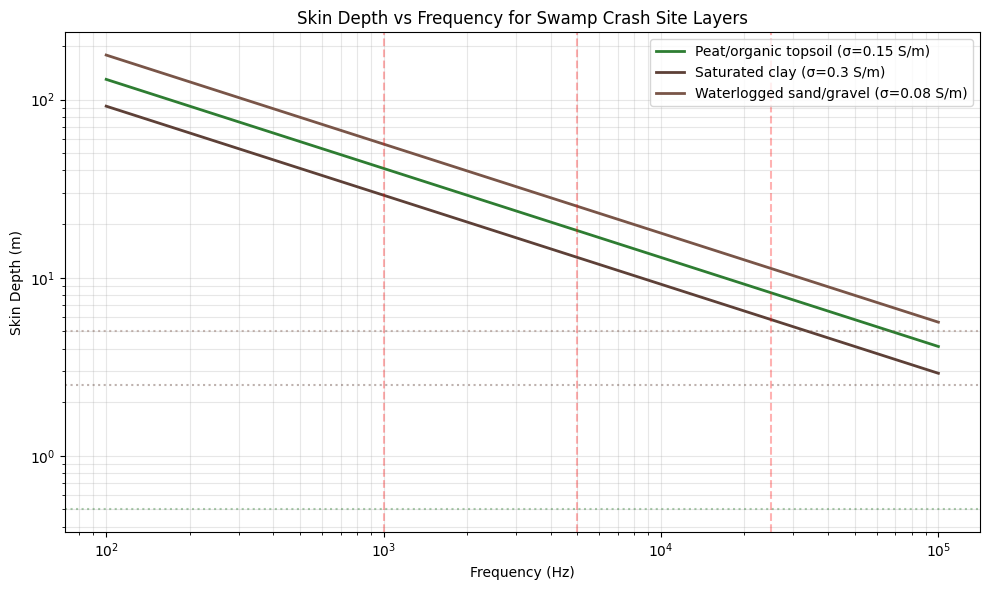

In [5]:
# Skin depth vs frequency for each layer
freqs = np.logspace(2, 5, 200)  # 100 Hz to 100 kHz

fig, ax = plt.subplots(figsize=(10, 6))

colors = ['#2E7D32', '#5D4037', '#795548']
for i, layer in enumerate(scenario.terrain.layers):
    delta = skin_depth(freqs, layer.conductivity)
    ax.loglog(freqs, delta, color=colors[i], lw=2,
              label=f'{layer.name} (\u03c3={layer.conductivity} S/m)')
    thickness = abs(layer.z_top - layer.z_bottom)
    ax.axhline(thickness, color=colors[i], ls=':', alpha=0.4)

# HIRT frequencies
for f in hirt_freqs:
    ax.axvline(f, color='red', ls='--', alpha=0.3)

ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Skin Depth (m)')
ax.set_title('Skin Depth vs Frequency for Swamp Crash Site Layers')
ax.legend()
ax.grid(True, alpha=0.3, which='both')

plt.tight_layout()

## 3. Conductive Sphere Response (Wait, 1951)

A buried conductive sphere in a uniform oscillating field produces a secondary
field characterized by the induction number $\alpha = r/\delta$:

- **Low induction** ($\alpha \ll 1$): response $\propto \sigma \omega r^5$ (quadrature-dominated)
- **High induction** ($\alpha \gg 1$): response saturates (in-phase-dominated)

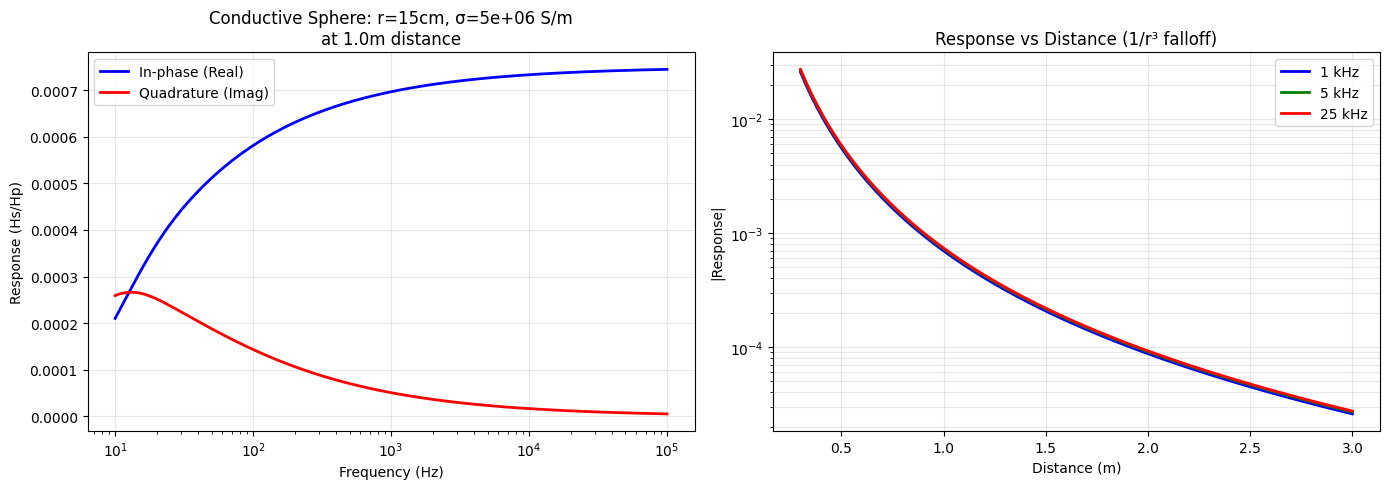

In [6]:
# Frequency sweep for a conductive sphere
freqs_sweep = np.logspace(1, 5, 200)
radius = 0.15  # 15 cm sphere
sigma = 5e6    # steel
r_obs = 1.0    # 1m observation distance

responses = [secondary_field_conductive_sphere(radius, sigma, f, r_obs) for f in freqs_sweep]
real_parts = [r.real for r in responses]
imag_parts = [r.imag for r in responses]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Real and imaginary vs frequency
ax1.semilogx(freqs_sweep, real_parts, 'b-', lw=2, label='In-phase (Real)')
ax1.semilogx(freqs_sweep, imag_parts, 'r-', lw=2, label='Quadrature (Imag)')
ax1.set_xlabel('Frequency (Hz)')
ax1.set_ylabel('Response (Hs/Hp)')
ax1.set_title(f'Conductive Sphere: r={radius*100:.0f}cm, \u03c3={sigma:.0e} S/m\nat {r_obs}m distance')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Distance falloff at 3 frequencies
distances = np.linspace(0.3, 3.0, 100)
for f, color, label in [(1000, 'blue', '1 kHz'), (5000, 'green', '5 kHz'), (25000, 'red', '25 kHz')]:
    resp = [abs(secondary_field_conductive_sphere(radius, sigma, f, d)) for d in distances]
    ax2.semilogy(distances, resp, color=color, lw=2, label=label)

ax2.set_xlabel('Distance (m)')
ax2.set_ylabel('|Response|')
ax2.set_title('Response vs Distance (1/r\u00b3 falloff)')
ax2.legend()
ax2.grid(True, alpha=0.3, which='both')

plt.tight_layout()

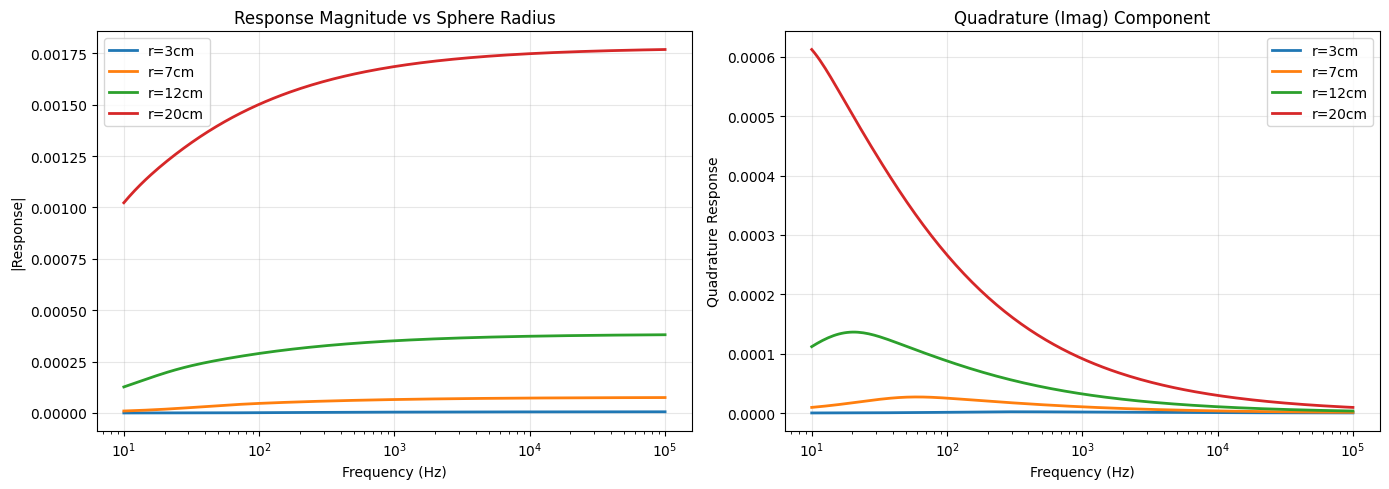

In [7]:
# Compare sphere sizes
radii = [0.03, 0.07, 0.12, 0.20]
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

for r in radii:
    resp = [secondary_field_conductive_sphere(r, sigma, f, 1.0) for f in freqs_sweep]
    ax1.semilogx(freqs_sweep, [abs(rr) for rr in resp], lw=2, label=f'r={r*100:.0f}cm')
    ax2.semilogx(freqs_sweep, [rr.imag for rr in resp], lw=2, label=f'r={r*100:.0f}cm')

ax1.set_xlabel('Frequency (Hz)')
ax1.set_ylabel('|Response|')
ax1.set_title('Response Magnitude vs Sphere Radius')
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2.set_xlabel('Frequency (Hz)')
ax2.set_ylabel('Quadrature Response')
ax2.set_title('Quadrature (Imag) Component')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()

## 4. Ranking Scenario EM Sources

The swamp crash site has 5 buried objects with different radii and conductivities.
Let's rank them by expected EM response magnitude at the probe midpoint.

In [8]:
em_sources = scenario.em_sources

# Use the midpoint between the two probes
probes = scenario.hirt_config.probes
midpoint = np.mean([p.position for p in probes], axis=0)
mid_depth = 0.5  # midway down probe
obs_point = np.array([midpoint[0], midpoint[1], -mid_depth])

print(f'Observation point: {obs_point}')
print()
print(f'{"Object":<30} {"Radius":>8} {"Sigma":>10} {"Distance":>10} {"Response @5kHz":>16}')
print('-' * 78)

results = []
for src in em_sources:
    pos = np.array(src['position'])
    dist = np.linalg.norm(pos - obs_point)
    resp = secondary_field_conductive_sphere(
        src['radius'], src['conductivity'], 5000.0, dist
    )
    results.append((src['name'], src['radius'], src['conductivity'], dist, abs(resp)))

# Sort by response magnitude
results.sort(key=lambda x: x[4], reverse=True)
for name, r, sigma, dist, resp in results:
    print(f'{name:<30} {r*100:>6.0f}cm {sigma:>10.0e} {dist:>9.2f}m {resp:>16.6e}')

Observation point: [12.5 12.5 -0.5]

Object                           Radius      Sigma   Distance   Response @5kHz
------------------------------------------------------------------------------
Engine block (submerged)           20cm      5e+06      2.12m     1.818405e-04
Propeller hub                      12cm      4e+06      3.08m     1.254371e-05
Wing root fitting                   7cm      3e+06      2.96m     2.696643e-06
Ammunition box cluster              5cm      2e+06      3.65m     4.901879e-07
Control cable bundle                3cm      1e+06      2.92m     1.689878e-07


## 5. 1D Layered-Earth FDEM Response

The `fdem_response_1d()` function computes the apparent conductivity measured
by horizontal coplanar (HCP) coils over a layered half-space, using McNeill's
(1980) cumulative sensitivity approach.

Swamp layered model:
  Layer 1: Peat/organic topsoil, sigma=0.15 S/m, thickness=0.5m
  Layer 2: Saturated clay, sigma=0.3 S/m, thickness=2.5m
  Layer 3: Waterlogged sand/gravel, sigma=0.08 S/m, thickness=infm


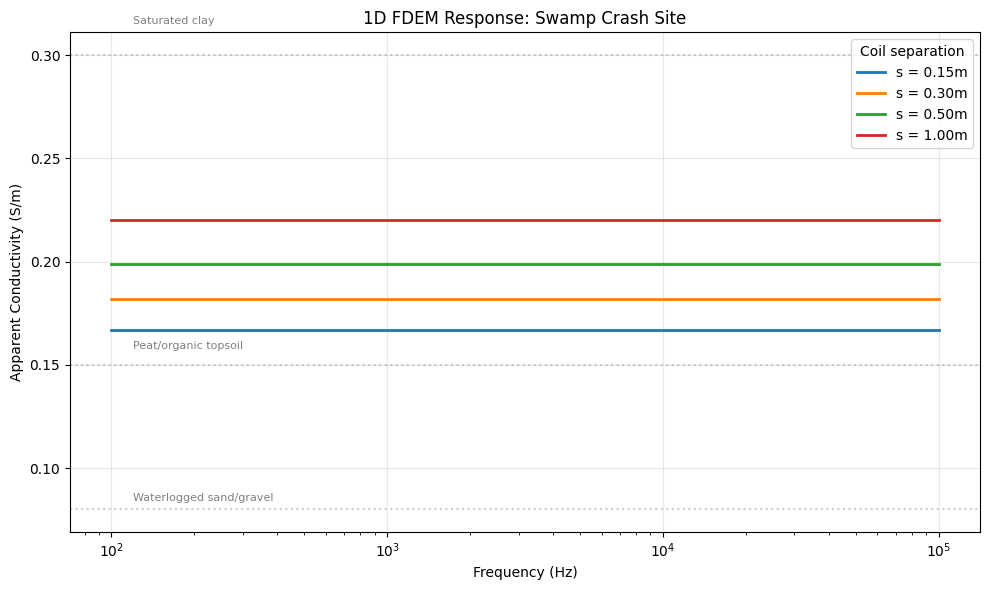

In [9]:
# Swamp 3-layer model
layers = scenario.terrain.layers
thicknesses = [abs(layers[0].z_top - layers[0].z_bottom),
               abs(layers[1].z_top - layers[1].z_bottom)]
conductivities = [layer.conductivity for layer in layers]

print('Swamp layered model:')
for i, layer in enumerate(layers):
    h = thicknesses[i] if i < len(thicknesses) else 'inf'
    print(f'  Layer {i+1}: {layer.name}, sigma={layer.conductivity} S/m, thickness={h}m')

# Apparent conductivity vs frequency for different coil separations
freqs = np.logspace(2, 5, 100)
separations = [0.15, 0.30, 0.50, 1.00]

fig, ax = plt.subplots(figsize=(10, 6))
for sep in separations:
    sigma_a = [fdem_response_1d(thicknesses, conductivities, f, sep).real for f in freqs]
    ax.semilogx(freqs, sigma_a, lw=2, label=f's = {sep:.2f}m')

# Mark true layer conductivities
for layer in layers:
    ax.axhline(layer.conductivity, color='gray', ls=':', alpha=0.4)
    ax.text(120, layer.conductivity * 1.05, f'{layer.name}', fontsize=8, color='gray')

ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Apparent Conductivity (S/m)')
ax.set_title('1D FDEM Response: Swamp Crash Site')
ax.legend(title='Coil separation')
ax.grid(True, alpha=0.3)

plt.tight_layout()

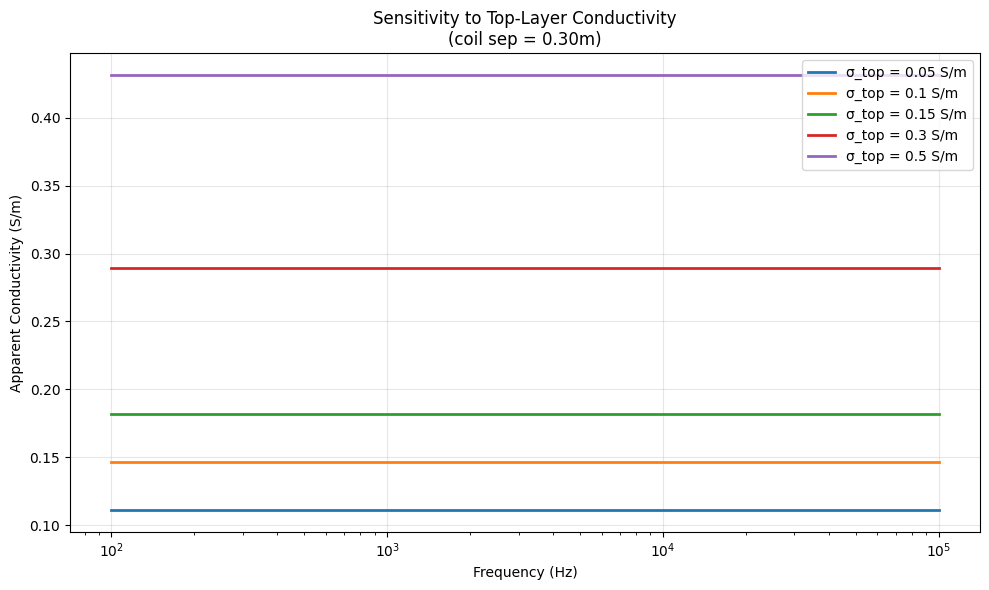

In [10]:
# Sensitivity study: vary top-layer conductivity
sigma_top_values = [0.05, 0.10, 0.15, 0.30, 0.50]
sep = 0.30  # 30cm coil separation (typical HIRT intra-probe)

fig, ax = plt.subplots(figsize=(10, 6))
for sigma_top in sigma_top_values:
    conds = [sigma_top] + conductivities[1:]
    sigma_a = [fdem_response_1d(thicknesses, conds, f, sep).real for f in freqs]
    ax.semilogx(freqs, sigma_a, lw=2, label=f'\u03c3_top = {sigma_top} S/m')

ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Apparent Conductivity (S/m)')
ax.set_title('Sensitivity to Top-Layer Conductivity\n(coil sep = 0.30m)')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()

## 6. Full FDEM Forward Model

The `fdem_forward()` function computes the complete sounding curve: response
at multiple frequencies for a given coil configuration.

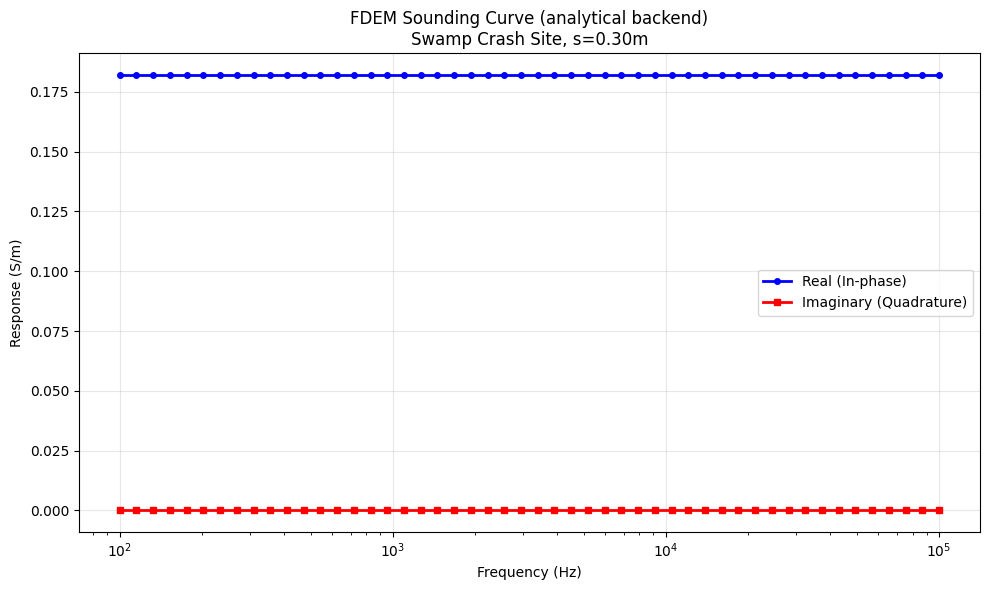

In [11]:
# FDEM sounding curve for the swamp model
freq_list = np.logspace(2, 5, 50).tolist()  # 100 Hz to 100 kHz
result = fdem_forward(
    thicknesses=thicknesses,
    conductivities=conductivities,
    frequencies=freq_list,
    coil_separation=0.30,
    height=0.0,
    backend='analytical',
)

fig, ax = plt.subplots(figsize=(10, 6))
ax.semilogx(result['frequencies'], result['real'], 'b-o', lw=2, markersize=4, label='Real (In-phase)')
ax.semilogx(result['frequencies'], result['imag'], 'r-s', lw=2, markersize=4, label='Imaginary (Quadrature)')

ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Response (S/m)')
ax.set_title(f'FDEM Sounding Curve ({result["backend"]} backend)\nSwamp Crash Site, s=0.30m')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()

## 7. HIRT Coil Configuration

The HIRT probe has 3 TX + 3 RX coils wound on a 40mm diameter former.
The `hirt_default_coils()` function returns the standard configuration.

Probe length: 1.0m
Probe diameter: 40mm
Total coils: 6 (3 TX + 3 RX)



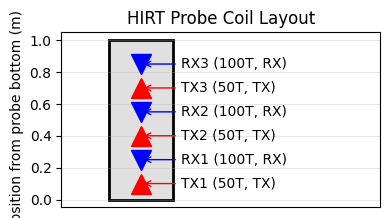

In [12]:
coils = hirt_default_coils()

print(f'Probe length: {coils.probe_length}m')
print(f'Probe diameter: {coils.probe_diameter*1000:.0f}mm')
print(f'Total coils: {coils.n_coils} ({len(coils.transmitters)} TX + {len(coils.receivers)} RX)')
print()

# Schematic diagram
fig, ax = plt.subplots(figsize=(4, 10))

# Draw probe body
probe_w = coils.probe_diameter * 10  # scale for visibility
ax.add_patch(plt.Rectangle((-probe_w/2, 0), probe_w, coils.probe_length,
             fill=True, facecolor='#E0E0E0', edgecolor='black', lw=2))

for coil in coils.coils:
    color = 'red' if coil.role == 'tx' else 'blue'
    marker = '^' if coil.role == 'tx' else 'v'
    ax.plot(0, coil.position, marker, color=color, markersize=15)
    ax.annotate(f'{coil.label} ({coil.turns}T, {coil.role.upper()})',
                (0, coil.position), xytext=(probe_w/2 + 0.05, coil.position),
                fontsize=10, va='center',
                arrowprops=dict(arrowstyle='->', color=color))

ax.set_xlim(-0.5, 1.5)
ax.set_ylim(-0.05, coils.probe_length + 0.05)
ax.set_ylabel('Position from probe bottom (m)')
ax.set_title('HIRT Probe Coil Layout')
ax.set_aspect('equal')
ax.grid(True, alpha=0.3, axis='y')
ax.set_xticks([])

plt.tight_layout()

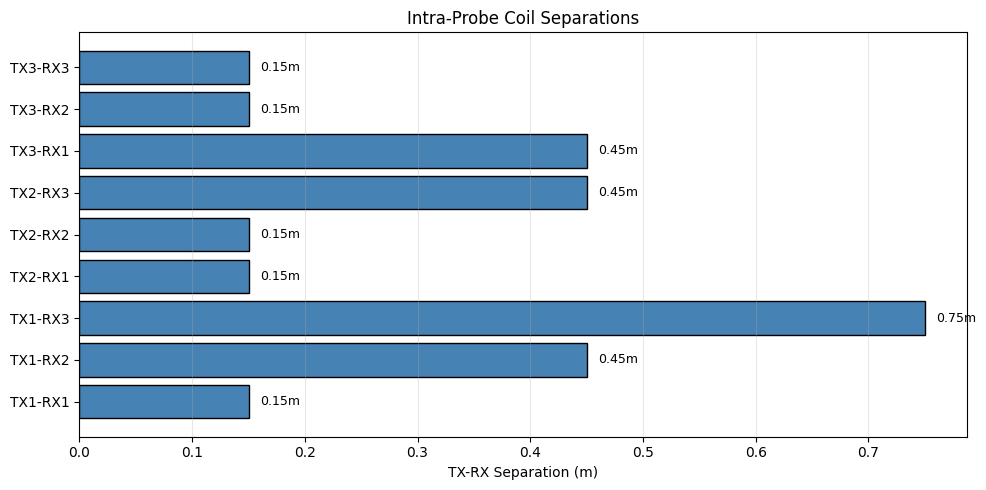

In [13]:
# TX-RX separation histogram (all possible intra-probe combinations)
separations = []
labels = []
for tx in coils.transmitters:
    for rx in coils.receivers:
        sep = abs(tx.position - rx.position)
        separations.append(sep)
        labels.append(f'{tx.label}-{rx.label}')

fig, ax = plt.subplots(figsize=(10, 5))
bars = ax.barh(labels, separations, color='steelblue', edgecolor='black')
ax.set_xlabel('TX-RX Separation (m)')
ax.set_title('Intra-Probe Coil Separations')
ax.grid(True, alpha=0.3, axis='x')

for bar, sep in zip(bars, separations):
    ax.text(sep + 0.01, bar.get_y() + bar.get_height()/2,
            f'{sep:.2f}m', va='center', fontsize=9)

plt.tight_layout()

## 8. Combined Pseudosection

For each coil separation and frequency, we can compute the apparent conductivity.
This creates a pseudosection — a 2D image showing how the response varies
with depth sensitivity (controlled by coil separation and frequency).

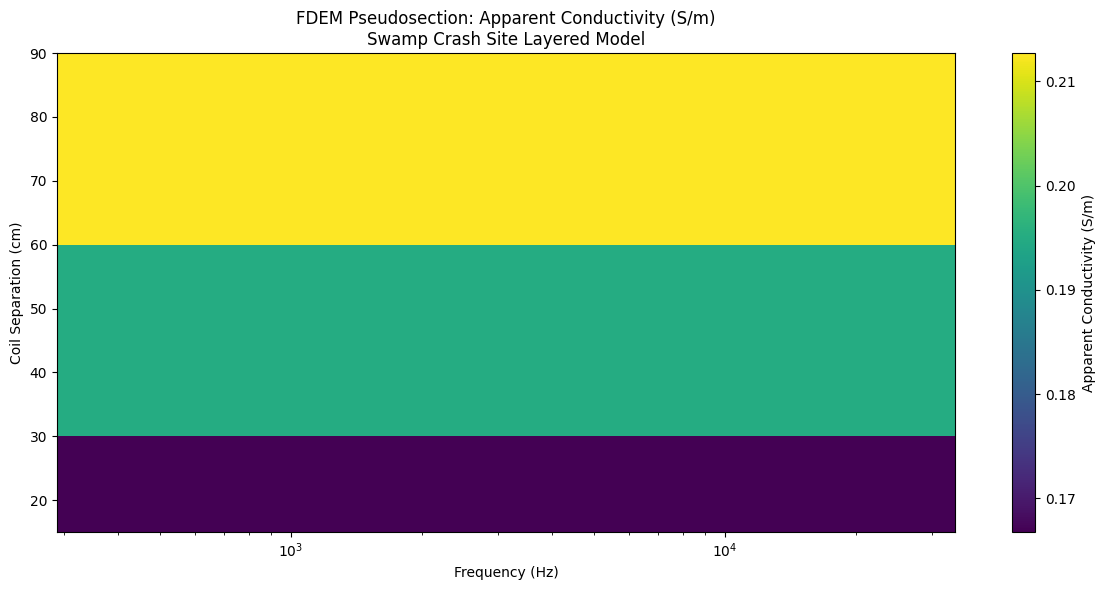

In [14]:
# Pseudosection: coil separation x frequency
freq_grid = np.logspace(2.5, 4.5, 30)  # 300 Hz to 30 kHz
sep_grid = np.array(sorted(set(separations)))  # unique separations

response_map = np.zeros((len(sep_grid), len(freq_grid)))
for i, sep in enumerate(sep_grid):
    for j, freq in enumerate(freq_grid):
        resp = fdem_response_1d(thicknesses, conductivities, freq, sep)
        response_map[i, j] = resp.real

fig, ax = plt.subplots(figsize=(12, 6))
im = ax.pcolormesh(
    freq_grid, sep_grid * 100, response_map,
    cmap='viridis', shading='auto',
)
ax.set_xscale('log')
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Coil Separation (cm)')
ax.set_title('FDEM Pseudosection: Apparent Conductivity (S/m)\nSwamp Crash Site Layered Model')
plt.colorbar(im, ax=ax, label='Apparent Conductivity (S/m)')

plt.tight_layout()

## Key Takeaways

1. **Skin depth** decreases with frequency and conductivity — HIRT uses multi-frequency to probe different depths
2. **The practical formula** ($\delta \approx 503\sqrt{\rho/f}$) matches the exact formula to machine precision
3. **Conductive sphere** response transitions from quadrature-dominated (low freq) to in-phase (high freq)
4. **Response magnitude scales as r\u00b3** from source and falls off as r\u00b3 with distance
5. **Layered-earth FDEM** shows frequency-dependent depth sensitivity via McNeill's cumulative sensitivity
6. **HIRT's 3+3 coil geometry** provides 9 unique TX-RX separations per probe, each sampling different depths
7. **The swamp's high conductivity** (0.3 S/m clay) limits skin depth to ~3m at 1 kHz — deep objects need low frequencies

Next: [05-ert-fundamentals.ipynb](05-ert-fundamentals.ipynb) — Electrical resistivity tomography